# Tutorial 02: Geodesics

Now that you have mastered the basics of computing optimal transport transforms, it is now time to apply that knowledge to something more useful. In many optimal transport papers, the authors plot the geodesic between two signals to demonstrate how mass is moved from one location to another. In this tutorial, you will learn how to reproduce these plots in your own work.

## Import Packages

Identically to the first tutorial, we will use Numpy for array manipulation and matplotlib for plotting results. We also need to reload the optimaltransport Python package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Add the optrans package to the Python path
# (change the path below to the location of the optimaltransport directory on your computer)
# Note: this step is not necessary if you have installed optimaltransport through pip.
import sys
sys.path.append('../../optimaltransport')

## Geodesics for 1D Signals

Let us first generate two sample 1D signals. In this example, we will use two translated Gaussian PDFs as our signal and reference. As before `sig0` is the reference signal, and `sig1` is the signal of interest.

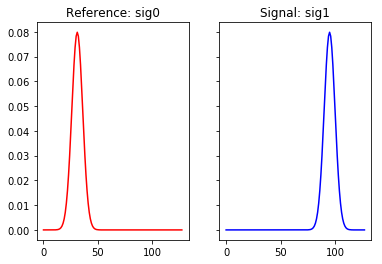

In [2]:
from optrans.utils import signal_to_pdf

# Create a delta function reference
sig0 = np.zeros(128)
sig0[31] = 1.

# Create a delta function signal
sig1 = np.zeros(128)
sig1[95] = 1.

# Convert the reference and signal to PDFs, and smooth them such that they become translated Gaussians
sig0 = signal_to_pdf(sig0, sigma=5.)
sig1 = signal_to_pdf(sig1, sigma=5.)

# Plot the signals
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(sig0, 'r-')
ax[0].set_title('Reference: sig0')
ax[1].plot(sig1, 'b-')
ax[1].set_title('Signal: sig1')
plt.show()

To demonstrate the power of the geodesic in transport space, we will first compute the "geodesic'' in image space by linearly interpolating between the two signals.

$$
I_\alpha(x) = (1-\alpha) I_0(x) + \alpha I_1(x), \quad 0 \leq \alpha \leq 1
$$

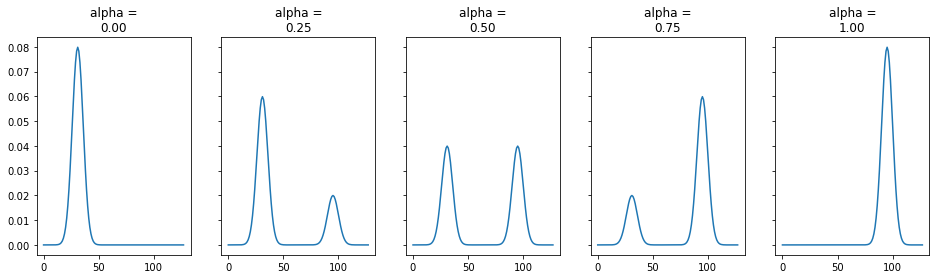

In [3]:
# alpha values to plot
alpha = np.linspace(0, 1, 5)

fig, ax = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16,4))
for i,a in enumerate(alpha):
    # Interpolation in signal space
    sig_interp = (1. - a) * sig0 + a * sig1
    ax[i].plot(sig_interp)
    ax[i].set_title('alpha =\n{:.2f}'.format(a))
plt.show()

As we can see, as $\alpha$ increases, the signal changes from a single Gaussian peak, to two peaks, and then back to one peak. If we were plotting the linear interpolation between images of a single healthy liver cell and a single cancerous liver cell, rather than these Gaussian signals, then for $0 < \alpha < 1$, the images would contain more than one cell. If the aim is to plot the change in the cells over time, this is obviously an unwanted effect.

We can correct this problem by linearly interpolating in transport space, rather than image space. In doing so, we plot the smooth geodesic between the two signals. First, let's compute the CDT of our signal `sig1` with respect to the reference `sig0`.

In [4]:
from optrans.continuous import CDT

# Compute CDT of sig1 w.r.t. sig0
cdt = CDT()
sig1_hat = cdt.forward(sig0, sig1)

We can plot the geodesic between the signals by computing the transport map $f_\alpha$ for different values of $\alpha$ and inverting back to signal space. To achieve this, we use the displacements $u$ computed during the forward CDT transform.

$$
I_\alpha(x) = (f_\alpha^{-1})'I_0(f_\alpha^{-1}(x)), \quad \textrm{where} \quad f_\alpha(x) = x - \alpha u(x)
$$

In order to invert the transform back into signal space, we make use of the `apply_inverse_map()` function to reconstruct the signal $I_\alpha$.

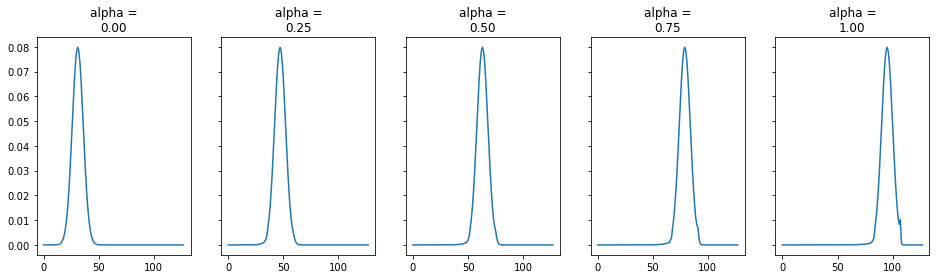

In [5]:
# Compute identity: x = f + u
x = cdt.transport_map_ + cdt.displacements_

# Plot interpolation in CDT space using same alpha values as before
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(16,4))
for i,a in enumerate(alpha):
    # Interpolation in CDT space
    fa = x - a * cdt.displacements_
    siga = cdt.apply_inverse_map(fa, sig0)
    ax[i].plot(siga)
    ax[i].set_title('alpha =\n{:.2f}'.format(a))
plt.show()

The transition between the two signals is now smooth, and for all values of $\alpha$ there exists only one Gaussian peak.

## Geodesics for 2D Images

In this section we will plot the 2D equivalent of the "moving Gaussian" example above. As before, let's create two translated Gaussian PDFs to act as our sample image `img1` and reference `img0.

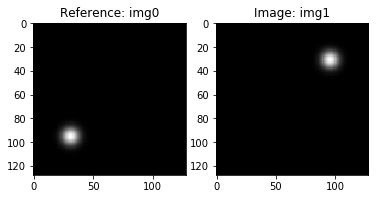

In [6]:
from optrans.utils import signal_to_pdf

# Create a delta function reference
img0 = np.zeros((128,128))
img0[95,31] = 1.

# Create a delta function image
img1 = np.zeros((128,128))
img1[31,95] = 1.

# Convert the reference and image to PDFs, and smooth them such that they become translated Gaussians
img0 = signal_to_pdf(img0, sigma=5.)
img1 = signal_to_pdf(img1, sigma=5.)

# Plot the images
_, ax = plt.subplots(1, 2)
ax[0].imshow(img0, cmap='gray')
ax[0].set_title('Reference: img0')
ax[1].imshow(img1, cmap='gray')
ax[1].set_title('Image: img1')
plt.show()

To highlight the difference between interpolation in Euclidean (image) space and 2-Wasserstein (transport) space, we will first plot the direct linear interpolation of the two images.

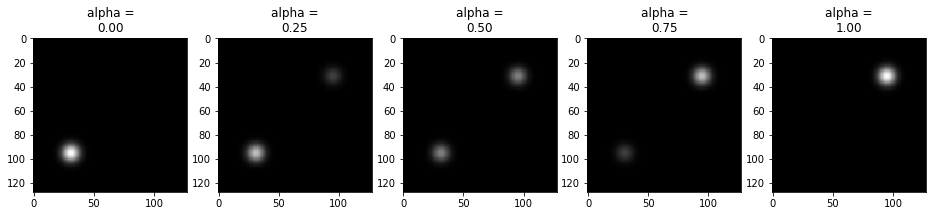

In [7]:
# alpha values to plot
alpha = np.linspace(0, 1, 5)

# Minimum and maximum pixel values (for plotting purposes)
vmin = img0.min()
vmax = img0.max()

fig, ax = plt.subplots(1, 5, figsize=(16,4))
for i,a in enumerate(alpha):
    # Interpolation in image space
    img_interp = (1. - a) * img0 + a * img1
    ax[i].imshow(img_interp, cmap='gray', vmin=vmin, vmax=vmax)
    ax[i].set_title('alpha =\n{:.2f}'.format(a))

Identically to the 1D case, for $0 < \alpha < 1$ there are two Gaussian peaks in the reconstructed image, rather than one. This can be corrected by computing the geodesic in transport space. To achieve this, we must first compute the forward Radon-CDT transform of `img1` with respect to `img0`, then calculate the transport map $f_\alpha$ for different values of $\alpha$. The `apply_inverse_map()` function can be used to apply the newly computed map $f_\alpha$, and reconstruct the image $I_\alpha$ for that value of $\alpha$.

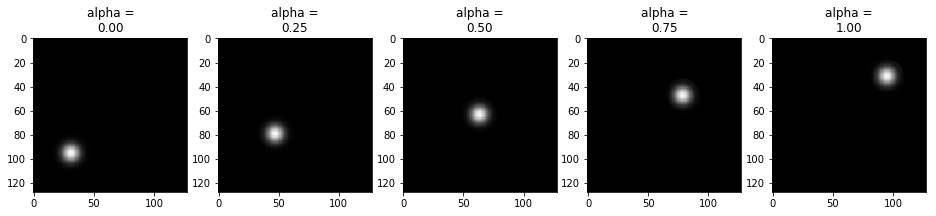

In [8]:
from optrans.continuous import RadonCDT

# Compute the Radon-CDT of img1 w.r.t. img0
radoncdt = RadonCDT()
img1_hat = radoncdt.forward(img0, img1)

# Compute identity: x = f + u
x = radoncdt.transport_map_ + radoncdt.displacements_

# Plot interpolation in Radon-CDT space using same alpha values as before
fig, ax = plt.subplots(1, 5, figsize=(16,4))
for i,a in enumerate(alpha):
    # Interpolation in Radon-CDT space
    fa = x - a * radoncdt.displacements_
    imga = radoncdt.apply_inverse_map(fa, img0)
    ax[i].imshow(imga, cmap='gray', vmin=vmin, vmax=vmax)
    ax[i].set_title('alpha =\n{:.2f}'.format(a))
plt.show()

The transition between the two images is now smooth, and for every value of $\alpha$, there exists only one Gaussian peak in the reconstruced image. This is identical to the result for the 1D example.